OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
  0%|          | 0/300 [00:00<?, ?it/s]

[0.5950179696083069, 0.1420903205871582, 0.003346290672197938, 0.008964837528765202] 379 66
[0.6626558303833008, 0.5908392071723938, 0.3233391344547272, 0.18158157169818878] 320 240
(4, 2, 3)


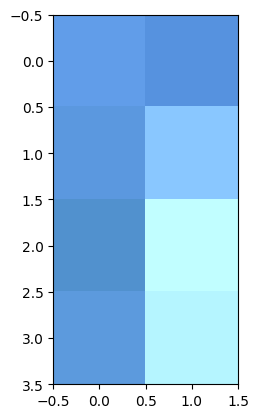

(87, 206, 3)


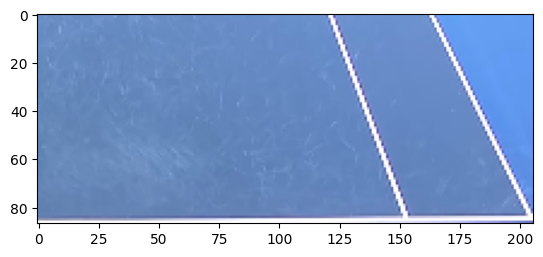

  0%|          | 0/300 [00:00<?, ?it/s]


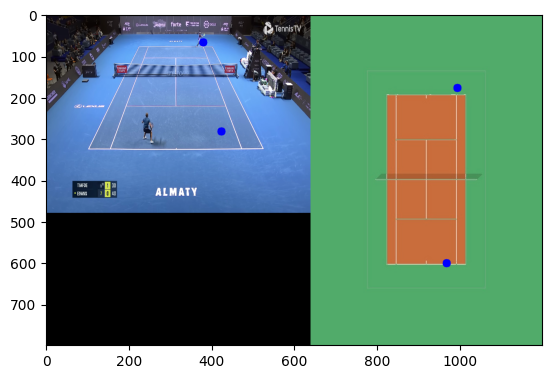

In [7]:
import cv2
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from tennis_tracker.download_data.extract_keypoints import read_json_file

FILE_PATH = (
    "/Users/derek/Desktop/tennis_tracker/tennis_tracker/ball_tracking/labels_base.json"
)
FPS = 30
FRAME_WIDTH, FRAME_HEIGHT = 640, 480
COURT_HEIGHT = 799
COURT_WIDTH = 560
VIDEO_PATH = "/Users/derek/Desktop/tennis_tracker/tennis_tracker/download_data/dataset/Tiafoe Takes On Evans; Khachanov& Mannarino Also In Action ｜ Almaty 2024 Highlights Day 4 [Q1iTjk444RU].webm"

def exract_box(image: np.ndarray, box: list[float]) -> np.ndarray:
    cx = int((box[0] - box[2]/2) * 640)
    cy = int((box[1] - box[3]/2) * 480)
    print(box, cx, cy)
    return image[cy:cy+int(box[3]*480), cx:cx+int(box[2]*640)]

def get_next_frame(data_entry: dict, court_image: np.array):
    """We want to get tracked points and draw them on the court image"""
    tracked_points = data_entry["ball_tracking_transformed_coords"]
    ball_tracking_boxes = data_entry["ball_tracking_boxes"]
    ball_tracking_boxes = [x.split(" ") for x in ball_tracking_boxes]
    ball_tracking_boxes = [[float(y) for y in x[1:]] for x in ball_tracking_boxes]
    original_image = cv2.imread(data_entry["actual_path"])
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    original_image = cv2.resize(original_image, (640, 480))
    all_image_boxes = []
    for point, box in zip(tracked_points, ball_tracking_boxes):
        cv2.circle(court_image, [int(p) for p in point], 10, (0, 0, 255), -1)
        all_image_boxes.append(exract_box(original_image.copy(), box))
        cv2.circle(original_image, [int(box[0] * 640), int(box[1] * 480)], 10, (0, 0, 255), -1)
    return tracked_points, all_image_boxes, original_image




data = read_json_file(FILE_PATH)

tiafoe_video_frames = []
keys = list(data.keys())
for key in keys:
    if "Tiafoe" in key:
        tiafoe_video_frames.append((key, int(key.split("/")[-1].split(".")[0])))

tiafoe_video_frames.sort(key=lambda x: x[1])
tiafoe_video_frames = [x[0] for x in tiafoe_video_frames]
video_capture = cv2.VideoCapture(VIDEO_PATH)
FPS = video_capture.get(cv2.CAP_PROP_FPS)

output_video = cv2.VideoWriter(
    "tennis_ball_tracking_output.mp4",
    cv2.VideoWriter_fourcc(*"XVID"),
    FPS,
    (FRAME_WIDTH + COURT_WIDTH, max(FRAME_HEIGHT, COURT_HEIGHT)),
)
start_idx = 2200

for i in tqdm(range(len(tiafoe_video_frames[:300]))):
    court_image = cv2.imread(
        "/Users/derek/Desktop/tennis_tracker/tennis_tracker/player_location/padded_court.jpg"
    )
    tracked_points, all_image_boxes, original_image = get_next_frame(
        data[tiafoe_video_frames[i + start_idx]], court_image
    )
    frame = np.zeros((max(FRAME_HEIGHT, COURT_HEIGHT), FRAME_WIDTH + COURT_WIDTH, 3), dtype=np.uint8)
    frame[:FRAME_HEIGHT, :FRAME_WIDTH, :] = original_image
    frame[:COURT_HEIGHT, FRAME_WIDTH:FRAME_WIDTH + COURT_WIDTH, :] = court_image
    for image_box in all_image_boxes:
        print(image_box.shape)
        plt.imshow(image_box)
        plt.show()
    break
plt.imshow(frame)
plt.show()
